# AlphaZero

This notebook is based on the paper:

* [Mastering the game of Go without Human Knowledge](https://deepmind.com/research/publications/mastering-game-go-without-human-knowledge/)

with additional insight from:

* https://applied-data.science/blog/how-to-build-your-own-alphazero-ai-using-python-and-keras/
* https://github.com/AppliedDataSciencePartners/DeepReinforcementLearning
* https://github.com/junxiaosong/AlphaZero_Gomoku/blob/master/mcts_alphaZero.py


This code use the new [conx](http://conx.readthedocs.io/en/latest/) layer that sits on top of Keras. Conx is designed to be simpler than Keras, more intuitive, and integrated visualizations.

Currently this code requires the TensorFlow backend, as it has a function specific to TF.

## The Game

First, let's look at a specific game. We can use many, but for this demonstration we'll pick ConnectFour. There is a good code base of different games and a game engine in the [code](https://github.com/Calysto/aima3/) based on [Artificial Intelligence: A Modern Approach](http://aima.cs.berkeley.edu/).

If you would like to install aima3, you can use something like this in a cell:

```bash
! pip install aima3 -U --user
```

aima3 has other games that you can play as well as ConnectFour, including TicTacToe. 
aima3 has many AI algorithms wrapped up to play games. You can see more details about the game engine and ConnectFour here:

* https://github.com/Calysto/aima3/blob/master/notebooks/games.ipynb
* https://github.com/Calysto/aima3/blob/master/notebooks/connect_four.ipynb

and other resources in that repository.

We import some of these that will be useful in our AlphaZero exploration:

In [1]:
from aima3.games import (ConnectFour, RandomPlayer, 
                         MCTSPlayer, QueryPlayer, Player,
                         MiniMaxPlayer, AlphaBetaPlayer,
                         AlphaBetaCutoffPlayer)
import numpy as np

Let's make a game:

In [2]:
game = ConnectFour()

and play a game between two random players:

In [3]:
game.play_game(RandomPlayer("Random-1"), RandomPlayer("Random-2"))

Random-2 is thinking...
Random-2 makes action (1, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
X . . . . . . 
Random-1 is thinking...
Random-1 makes action (3, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
X . O . . . . 
Random-2 is thinking...
Random-2 makes action (5, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
X . O . X . . 
Random-1 is thinking...
Random-1 makes action (4, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
X . O O X . . 
Random-2 is thinking...
Random-2 makes action (3, 2):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . X . . . . 
X . O O X . . 
Random-1 is thinking...
Random-1 makes action (7, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . X . . . . 
X . O O X . O 
Random-2 is thinking...
Random-2 makes action 

['Random-1']

We can also play a match (a bunch of games) or even a tournament between a bunch of players.

```python
p1 = RandomPlayer("Random-1")
p2 = MiniMax("MiniMax-1")
p3 = AlphaBetaCutoff("ABCutoff-1")

game.play_matches(10, p1, p2)

game.play_tournament(1, p1, p2, p3)
```

Can you beat RandomPlayer? Hope so!

Can you beat MiniMax? No! But it takes too long.

Humans enter their commands by (column, row) where column starts at 1 from left, and row starts at 1 from bottom.

In [4]:
# game.play_game(AlphaBetaCutoffPlayer("AlphaBetaCutoff"), HumanPlayer("Your Name Here"))

## The Network

Net, we are going to build the same kind of network described in the AlphaZero paper.

Make sure to set your Keras backend to TensorFlow for now, as we have a function that is written at that level.

In [5]:
import conx as cx
from aima3.games import Game
from keras import regularizers

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
conx, version 3.5.14


In [6]:
## NEED TO REWRITE THIS FUNCTION IN KERAS:

import tensorflow as tf

def softmax_cross_entropy_with_logits(y_true, y_pred):
    p = y_pred
    pi = y_true
    zero = tf.zeros(shape = tf.shape(pi), dtype=tf.float32)
    where = tf.equal(pi, zero)
    negatives = tf.fill(tf.shape(pi), -100.0) 
    p = tf.where(where, negatives, p)
    loss = tf.nn.softmax_cross_entropy_with_logits(labels = pi, logits = p)
    return loss

### Representations

The state board is the most important bits of information. How to represent it? Possible ideas:

* a vector of 42 values
* a 6x7 matrix

We decided to represent the state of the board as 2 6x7 matrices: one for representing the current player's pieces, and the other for the opponent pieces.

We also need to represent actions. Possible ideas:

* 7 outputs, each representing a column to drop a piece into
* two outputs, one representing row, and the other column
* 6x7 matrix, each representing the position on the grid
* 42 outputs, each representing the position on the grid

We decided to represent them as the final option: 42 outputs.

The network architecture in AlphaZero is quite large, and has repeating blocks of layers. To help in the construction of the network, we define some functions

In [7]:
def add_conv_block(net, input_layer):
    cname = net.add(cx.Conv2DLayer("conv2d-%d", 
                    filters=75, 
                    kernel_size=(4,4), 
                    padding='same', 
                    use_bias=False,
                    activation='linear', 
                    kernel_regularizer=regularizers.l2(0.0001)))
    bname = net.add(cx.BatchNormalizationLayer("batch-norm-%d", axis=1))
    lname = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    net.connect(input_layer, cname)
    net.connect(cname, bname)
    net.connect(bname, lname)
    return lname

def add_residual_block(net, input_layer):
    prev_layer = add_conv_block(net, input_layer)
    cname = net.add(cx.Conv2DLayer("conv2d-%d",
        filters=75,
        kernel_size=(4,4),
        padding='same',
        use_bias=False,
        activation='linear',
        kernel_regularizer=regularizers.l2(0.0001)))
    bname = net.add(cx.BatchNormalizationLayer("batch-norm-%d", axis=1))
    aname = net.add(cx.AddLayer("add-%d"))
    lname = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    net.connect(prev_layer, cname)
    net.connect(cname, bname)
    net.connect(input_layer, aname)
    net.connect(bname, aname)
    net.connect(aname, lname)
    return lname

def add_value_block(net, input_layer):
    l1 = net.add(cx.Conv2DLayer("conv2d-%d",
        filters=1,
        kernel_size=(1,1),
        padding='same',
        use_bias=False,
        activation='linear',
        kernel_regularizer=regularizers.l2(0.0001)))
    l2 = net.add(cx.BatchNormalizationLayer("batch-norm-%d", axis=1))
    l3 = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    l4 = net.add(cx.FlattenLayer("flatten-%d"))
    l5 = net.add(cx.Layer("dense-%d",
        20,
        use_bias=False,
        activation='linear',
        kernel_regularizer=regularizers.l2(0.0001)))
    l6 = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    l7 = net.add(cx.Layer('value_head',
        1,
        use_bias=False,
        activation='tanh',
        kernel_regularizer=regularizers.l2(0.0001)))
    net.connect(input_layer, l1)
    net.connect(l1, l2)
    net.connect(l2, l3)
    net.connect(l3, l4)
    net.connect(l4, l5)
    net.connect(l5, l6)
    net.connect(l6, l7)
    return l7

def add_policy_block(net, input_layer):
    l1 = net.add(cx.Conv2DLayer("conv2d-%d",
        filters=2,
        kernel_size=(1,1),
        padding='same',
        use_bias=False,
        activation='linear',
        kernel_regularizer = regularizers.l2(0.0001)))
    l2 = net.add(cx.BatchNormalizationLayer("batch-norm-%d", axis=1))
    l3 = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    l4 = net.add(cx.FlattenLayer("flatten-%d"))
    l5 = net.add(cx.Layer('policy_head',
            42,
            use_bias=False,
            activation='linear',
            kernel_regularizer=regularizers.l2(0.0001)))
    net.connect(input_layer, l1)
    net.connect(l1, l2)
    net.connect(l2, l3)
    net.connect(l3, l4)
    net.connect(l4, l5)
    return l5

In [8]:
def make_network(game, residuals=5):
    net = cx.Network("AlphaZero Network")
    net.add(cx.Layer("main_input", (game.v, game.h, 2)))
    out_layer = add_conv_block(net, "main_input")
    for i in range(residuals):
        out_layer = add_residual_block(net, out_layer)
    add_policy_block(net, out_layer)
    add_value_block(net, out_layer)
    net.compile(loss={'value_head': 'mean_squared_error', 
                  'policy_head': softmax_cross_entropy_with_logits},
            optimizer=cx.SGD(lr=0.1, momentum=0.9),
            loss_weights={'value_head': 0.5, 
                          'policy_head': 0.5})
    for layer in net.layers:
        if layer.kind() == "hidden":
            layer.visible = False
    return net

In [9]:
game = ConnectFour()
net = make_network(game)

In [10]:
net.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 6, 7, 2)      0                                            
__________________________________________________________________________________________________
conv2d-1 (Conv2D)               (None, 6, 7, 75)     2400        main_input[0][0]                 
__________________________________________________________________________________________________
batch-norm-1 (BatchNormalizatio (None, 6, 7, 75)     24          conv2d-1[0][0]                   
__________________________________________________________________________________________________
leaky-relu-1 (LeakyReLU)        (None, 6, 7, 75)     0           batch-norm-1[0][0]               
__________________________________________________________________________________________________
conv2d-2 (

In [11]:
len(net.layers)

51

<IPython.core.display.Javascript object>


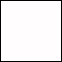
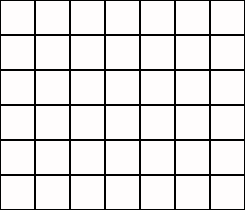

In [12]:
net.render()

## Connecting the Network to the Game

First, we need a mapping from game (x,y) moves to a position in a list of actions and probabilities.

In [13]:
def make_mappings(game):
    """
    Get a mapping from game's (x,y) to array position.
    """
    move2pos = {}
    pos2move = []
    position = 0
    for y in range(game.v, 0, -1):
        for x in range(1, game.h + 1):
            move2pos[(x,y)] = position
            pos2move.append((x,y))
            position += 1
    return move2pos, pos2move

We use the connectFour game, defined above:

In [14]:
move2pos, pos2move = make_mappings(game)

In [15]:
move2pos[(2,1)]

36

In [16]:
pos2move[35]

(1, 1)

Need a method of converting a list of state moves into an array:

In [17]:
def state2array(game, state):
    array = []
    to_move = game.to_move(state)
    for y in range(game.v, 0, -1):
        for x in range(1, game.h + 1):
            item = state.board.get((x, y), 0)
            if item != 0:
                item = 1 if item == to_move else -1
            array.append(item)
    return array

In [18]:
cx.shape(state2array(game, game.initial))

(42,)

So, state2array returns a list of 42 numbers, where:

* 0 represents an empty place
* 1 represents one of my pieces
* -1 represents one of my opponent's pieces

Note that "my" and "my opponent" may swap back and forth depending on perspective (ie, whose turn it is, as determined by game.to_move(state)).

In [19]:
def state2inputs(game, state):
    board = np.array(state2array(game, state)) # 1 is my pieces, -1 other
    currentplayer_position = np.zeros(len(board), dtype=np.int)
    currentplayer_position[board==1] = 1
    other_position = np.zeros(len(board), dtype=np.int)
    other_position[board==-1] = 1
    position = np.array(list(zip(currentplayer_position,other_position)))
    inputs = position.reshape((game.v, game.h, 2))
    return inputs.tolist()

We need to convert the state's board into a form for the neural network:

In [20]:
state2inputs(game, game.initial)

[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
 [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]]

We can check to see if this is correct by propagating the activations to the first layer.

Initial board state has no pieces on the board:

Feature 0,Feature 1

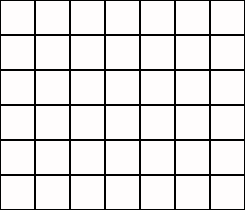
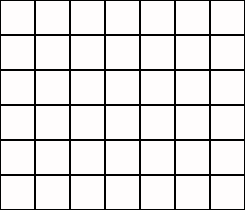

In [21]:
state = game.initial
net.propagate_to_features("main_input", state2inputs(game, state))

Now we make a move to (1,1). But note that after the move, it is now the other player's move. So the first move is seen on the opponent's board (the right side, feature #1):

Feature 0,Feature 1

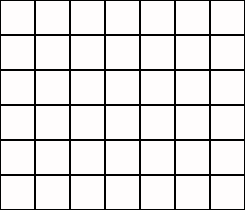
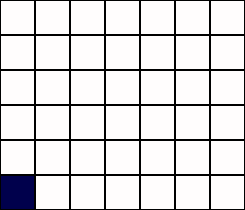

In [22]:
state = game.result(game.initial, (1,1))
net.propagate_to_features("main_input", state2inputs(game, state))

Now, the second player moves to (2,1). Now we are back to the original perspective, and so the right-hand board is on the left, because that is now the current player's perspective.

Feature 0,Feature 1

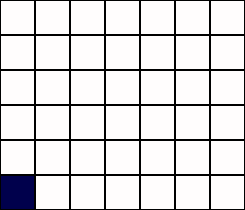
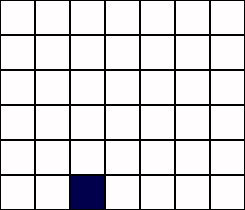

In [23]:
state = game.result(state, (3,1))
net.propagate_to_features("main_input", state2inputs(game, state))

Finally, we are ready to connect the game to the network. We define a function `get_predictions` that takes a game and state, and propagates it through the network returning a (value, probabilities, allowedActions). The probabilities are the pi list from the AlphaZero paper.

In [24]:
def get_predictions(net, game, state):
    """
    Given a state, give output of network on preferred
    actions. state.allowedActions removes impossible
    actions.

    Returns (value, probabilties, allowedActions)
    """
    board = np.array(state2array(game, state)) # 1 is my pieces, -1 other
    inputs = state2inputs(game, state)
    preds = net.propagate(inputs, visualize=True)
    value = preds[1][0]
    logits = np.array(preds[0])
    allowedActions = np.array([move2pos[act] for act in game.actions(state)])
    mask = np.ones(len(board), dtype=bool)
    mask[allowedActions] = False
    logits[mask] = -100
    #SOFTMAX
    odds = np.exp(logits)
    probs = odds / np.sum(odds) ###put this just before the for?
    return (value, probs.tolist(), allowedActions.tolist())

In [25]:
value, probs, acts = get_predictions(net, game, state)

<IPython.core.display.Javascript object>


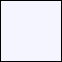
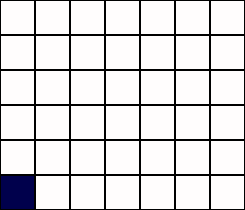

In [26]:
net.snapshot(state2inputs(game, state))

## Testing Game and Network Integration

Finally, we turn the predictions into a move, and we can play a game with the network.

In [27]:
class NNPlayer(Player):

    def set_game(self, game):
        """
        Get a mapping from game's (x,y) to array position.
        """
        self.net = make_network(game)
        self.game = game
        self.move2pos = {}
        self.pos2move = []
        position = 0
        for y in range(self.game.v, 0, -1):
            for x in range(1, self.game.h + 1):
                self.move2pos[(x,y)] = position
                self.pos2move.append((x,y))
                position += 1

    def get_predictions(self, state):
        """
        Given a state, give output of network on preferred
        actions. state.allowedActions removes impossible
        actions.

        Returns (value, probabilties, allowedActions)
        """
        board = np.array(self.state2array(state)) # 1 is my pieces, -1 other
        inputs = self.state2inputs(state)
        preds = self.net.propagate(inputs)
        value = preds[1][0]
        logits = np.array(preds[0])
        allowedActions = np.array([self.move2pos[act] for act in self.game.actions(state)])
        mask = np.ones(len(board), dtype=bool)
        mask[allowedActions] = False
        logits[mask] = -100
        #SOFTMAX
        odds = np.exp(logits)
        probs = odds / np.sum(odds) 
        return (value, probs.tolist(), allowedActions.tolist())
    
    def get_action(self, state, turn):
        value, probabilities, moves = self.get_predictions(state)
        probs = np.array(probabilities)[moves]
        pos = cx.choice(moves, probs)
        return self.pos2move[pos]

    def state2inputs(self, state):
        board = np.array(self.state2array(state)) # 1 is my pieces, -1 other
        currentplayer_position = np.zeros(len(board), dtype=np.int)
        currentplayer_position[board==1] = 1
        other_position = np.zeros(len(board), dtype=np.int)
        other_position[board==-1] = 1
        position = np.array(list(zip(currentplayer_position,other_position)))
        inputs = position.reshape((self.game.v, self.game.h, 2))
        return inputs

    def state2array(self, state):
        array = []
        to_move = self.game.to_move(state)
        for y in range(self.game.v, 0, -1):
            for x in range(1, self.game.h + 1):
                item = state.board.get((x, y), 0)
                if item != 0:
                    item = 1 if item == to_move else -1
                array.append(item)
        return array

In [28]:
p1 = RandomPlayer("Random")
p2 = NNPlayer("NNPlayer")

In [29]:
p2.set_game(game)

In [30]:
p2.get_action(state, 2)

(2, 1)

In [31]:
game.play_game(p1, p2)

NNPlayer is thinking...
NNPlayer makes action (2, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. X . . . . . 
Random is thinking...
Random makes action (4, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. X . O . . . 
NNPlayer is thinking...
NNPlayer makes action (5, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. X . O X . . 
Random is thinking...
Random makes action (4, 2):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . O . . . 
. X . O X . . 
NNPlayer is thinking...
NNPlayer makes action (5, 2):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . O X . . 
. X . O X . . 
Random is thinking...
Random makes action (5, 3):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . O . . 
. . . O X . . 
. X . O X . . 
NNPlayer is thinking...
NNPlayer makes action (3, 1):
. . 

['NNPlayer']

## Training The Network

Now we are ready to train the network. The training is a clever use of Monte Carlo Tree Search, combined with playing against itself.

There is a [Monte Carlo Tree Search player](https://github.com/Calysto/aima3/blob/master/notebooks/monte_carlo_tree_search.ipynb) in aima3 that we will use. We set the policy to come from predictions from the neural network.

In [32]:
class AlphaZeroMCTSPlayer(MCTSPlayer):
    """
    A Monte Carlo Tree Search with policy function from
    neural network. Network will be set later to self.nnplayer.
    """
    def policy(self, game, state):
        # these moves are positions:
        value, probs_all, moves = self.nnplayer.get_predictions(state)
        if len(moves) == 0:
            result = [], value
        else:
            probs = np.array(probs_all)[moves]
            moves = [self.nnplayer.pos2move[pos] for pos in moves]
            # we need to return probs and moves for game
            result = [(act, prob) for (act, prob) in list(zip(moves, probs))], value
        return result

The main AlphaZeroPlayer needs to be able to play in one of two modes:

* self_play: it plays against itself (using two different MCTS, as this version requires it). The network provides policy evaulation for each state is it looks ahead.
* regular play: moves come directly from the network

In [33]:
class AlphaZeroPlayer(NNPlayer):
    ## Load weights if continuing
    def __init__(self, name, n_playout=40, *args, **kwargs):
        super().__init__(name, *args, **kwargs)
        self.mcts_players = [AlphaZeroMCTSPlayer("MCTS-1", n_playout=n_playout),
                             AlphaZeroMCTSPlayer("MCTS-2", n_playout=n_playout)]
        
    def set_game(self, game):
        super().set_game(game)
        self.mcts_players[0].set_game(game)
        self.mcts_players[1].set_game(game)
        self.mcts_players[0].nnplayer = self
        self.mcts_players[1].nnplayer = self
        self.data = [[], []]
        self.cache = {}
        
    def get_action(self, state, turn, self_play):
        if self_play:
            ## Only way to determine which is which?
            if turn in self.cache:
                player_num = 1
            else:
                player_num = 0
                self.cache[turn] = True
            ## now use the policy to get some probs:
            move, pi = self.mcts_players[player_num].get_action(state, round(turn), return_prob=True)
            ## save the state and probs:
            self.data[player_num].append((self.state2inputs(state), self.move_probs2all_probs(pi)))
            return move
        else:
            # play the network, were're in the playoffs!
            return super().get_action(state, round(turn))

    def move_probs2all_probs(self, move_probs):
        all_probs = np.zeros(len(self.state2array(game.initial)))
        for move in move_probs:
            all_probs[self.move2pos[move]] = move_probs[move]
        return all_probs.tolist()

We now set up the game to play in one of the two modes. 

One complication when playing itself: the system isn't sure which one it is, and we want to separate the two plays! To keep track, we cache the turn; if we see the same turn again, then we know it is the second.

In [34]:
class AlphaZeroGame(ConnectFour):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.memory = []
        
    def play_game(self, *players, flip_coin=False, verbose=1, **kwargs):
        results = super().play_game(*players, flip_coin=flip_coin, verbose=verbose, **kwargs)
        if "self_play" in kwargs and kwargs["self_play"]:
            ## Do not allow flipping coins when self play:
            ## Assumes that player1 == player2 when self-playing
            assert flip_coin is False, "no coin_flip when self-playing"
            ## value is in terms of player 0
            value = self.final_utility
            for state, probs in players[0].data[0]:
                self.memory.append([state, [probs, [value]]])
            # also data from opponent, so flip value:
            value = -value
            for state, probs in players[1].data[1]:
                self.memory.append([state, [probs, [value]]])
        return results

In [35]:
game = AlphaZeroGame()
best_player = AlphaZeroPlayer("best_player")
current_player = AlphaZeroPlayer("current_player")

Some basic tests to make sure things are going in the right place:

In [36]:
current_player.set_game(game)
assert current_player.data == [[], []]
print(current_player.get_action(game.initial, 1, self_play=False))
assert current_player.data == [[], []]
print(current_player.get_action(game.initial, 1, self_play=True))
assert current_player.data[0] != []
print(current_player.get_action(game.initial, 1, self_play=True))
assert current_player.data[1] != []

(5, 1)
(4, 1)
(3, 1)


Sample just for testing:

In [37]:
game.play_tournament(1, best_player, best_player, verbose=1, mode="ordered", self_play=True)

Tournament to begin with 2 matches...
best_player is thinking...
best_player makes action (3, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . X . . . . 
best_player is thinking...
best_player makes action (7, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . X . . . O 
best_player is thinking...
best_player makes action (2, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. X X . . . O 
best_player is thinking...
best_player makes action (6, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. X X . . O O 
best_player is thinking...
best_player makes action (1, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
X X X . . O O 
best_player is thinking...
best_player makes action (4, 1):
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. . . . . . . 
. 

{'DRAW': 0, 'best_player': 2}

Did we collect some history?

In [38]:
len(game.memory)

26

Ok, we are ready to learn!

In [49]:
config = dict(
    MINIMUM_MEMORY_SIZE_BEFORE_TRAINING = 1000, # min size of memory
    TRAINING_EPOCHS_PER_CYCLE = 500, # training on current network
    CYCLES = 1, # number of cycles to run
    SELF_PLAY_MATCHES = 1, # matches to test yo' self per self-play round
    TOURNAMENT_MATCHES = 2, # plays each player as first mover per match, so * 2
    BEST_SWAP_PERCENT = 1.0, # you must be this much better than best
)

In [51]:
def alphazero_train(config):
    ## Uses global game, best_player, and current_player
    for cycle in range(config["CYCLES"]):
        print("Epoch #%s..." % cycle)
        # self-play, collect data:
        print("Self-play matches begin...")
        while len(game.memory) < config["MINIMUM_MEMORY_SIZE_BEFORE_TRAINING"]:
            results = game.play_tournament(config["SELF_PLAY_MATCHES"], 
                                           best_player, best_player, 
                                           mode="ordered", self_play=True)
            print("Memory size is %s" % len(game.memory))
        print("Enough to train!")
        current_player.net.dataset.clear()
        current_player.net.dataset.load(game.memory)
        print("Training on ", len(current_player.net.dataset.inputs), "patterns...")
        current_player.net.train(config["TRAINING_EPOCHS_PER_CYCLE"], 
                                 batch_size=len(game.memory),
                                 plot=True)
        ## save dataset every once in a while
        ## now see which net is better:
        print("Playing best vs current to see who wins the title...")
        results = game.play_tournament(config["TOURNAMENT_MATCHES"], 
                                       best_player, current_player, 
                                       mode="one-each", self_play=False)
        if results["current_player"] > results["best_player"] * config["BEST_SWAP_PERCENT"]:
            print("current won! swapping weights")
            # give the better weights to the best_player
            best_player.net.set_weights(
                current_player.net.get_weights())
            game.memory = []
        else:
            print("best won!")

In [ ]:
alphazero_train(config)

Epoch #0...
Self-play matches begin...
Memory size is 171
Memory size is 208
Memory size is 247
Memory size is 284
Memory size is 310
Memory size is 349
Memory size is 387
Memory size is 425
Memory size is 455
Memory size is 481
Memory size is 541
Memory size is 571
Memory size is 608
Memory size is 657
Memory size is 703
Memory size is 744
Memory size is 788
Memory size is 833
Memory size is 878
Memory size is 920
Memory size is 979
Memory size is 1028
Enough to train!
Training on  1028 patterns...
Training...
       |  Training |    policy |     value 
Epochs |     Error |  head acc |  head acc 
------ | --------- | --------- | --------- 
#  801 |   0.39601 |   0.00000 |   0.92708 
#  802 |   1.03875 |   0.00000 |   0.27140 
#  803 |   0.87153 |   0.00000 |   0.15953 
#  804 |   0.79308 |   0.00000 |   0.18191 
#  805 |   0.73491 |   0.00000 |   0.29475 
#  806 |   0.73332 |   0.00000 |   0.35019 
#  807 |   0.70390 |   0.00000 |   0.36868 
#  808 |   0.67224 |   0.00000 |   0.40467 

#  973 |   0.52743 |   0.00000 |   0.71109 
#  974 |   0.51828 |   0.00000 |   0.73152 
#  975 |   0.51169 |   0.00000 |   0.75681 
#  976 |   0.50040 |   0.00000 |   0.77626 
#  977 |   0.49987 |   0.00000 |   0.80545 
#  978 |   0.49475 |   0.00000 |   0.79961 
#  979 |   0.48799 |   0.00000 |   0.82685 
#  980 |   0.48720 |   0.00000 |   0.83171 
#  981 |   0.48790 |   0.00000 |   0.84241 
#  982 |   0.48720 |   0.00000 |   0.82296 
#  983 |   0.48248 |   0.00000 |   0.83366 
#  984 |   0.48260 |   0.00000 |   0.85019 
#  985 |   0.48272 |   0.00000 |   0.83560 
#  986 |   0.48424 |   0.00000 |   0.82101 
#  987 |   0.48143 |   0.00000 |   0.84047 
#  988 |   0.48048 |   0.00000 |   0.82977 
#  989 |   0.47887 |   0.00000 |   0.84922 
#  990 |   0.48022 |   0.00000 |   0.84241 
#  991 |   0.47867 |   0.00000 |   0.84533 
#  992 |   0.47878 |   0.00000 |   0.84241 
#  993 |   0.47876 |   0.00000 |   0.83560 
#  994 |   0.47767 |   0.00000 |   0.84144 
#  995 |   0.47786 |   0.00000 |

In [40]:
len(game.memory)

133

Let's train best_player some more:

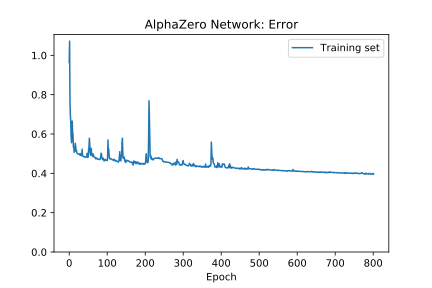

Interrupted! Cleaning up...
       |  Training |    policy |     value 
Epochs |     Error |  head acc |  head acc 
------ | --------- | --------- | --------- 
#  801 |   0.39601 |   0.00000 |   0.92708 


KeyboardInterrupt: 

In [48]:
best_player.net.train(1000, report_rate=5, plot=True)

In [44]:
best_player.net["policy_head"].vshape = (6,7)
best_player.net.config["show_targets"] = True

In [45]:
best_player.net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=1.0, continuous_update=False, description='Zoom', max=3.0, min=0.5), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=True, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('', 'main_input', 'conv2d-1', 'batch-norm-1', 'leaky-relu-1', 'conv2d-2', 'batch-norm-2', 'leaky-relu-2', 'conv2d-3', 'batch-norm-3', 'add-1', 'leaky-relu-3', 'conv2d-4', 'batch-norm-4', 'leaky-relu-4', 'conv2d-5', 'batch-norm-5', 'add-2', 'leaky-relu-5', 'conv2d-6', 'batch-norm-6', 'leaky-relu-6', 'conv2d-7', 'batch-norm-7', 'add-3', 'leaky-relu-7', 'conv2d-8', 'batch-norm-8', 'leaky-relu-8', 'conv2d-9', 'batch-norm-9', 'add-4', 'leaky-relu-9', 'conv2d-10', 'batch-norm-10', 'leaky-relu-10', 'conv2d-11', 'batch-norm-11', 'add-5', 'leaky-relu-11', 'conv2d-12', 'batch-norm-12', 'leaky-relu-12', 'conv2d-13', 'batch-norm-13', 'leaky-relu-13'), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=2.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=50, options=('main_input', 'conv2d-1', 'batch-norm-1', 'leaky-relu-1', 'conv2d-2', 'batch-norm-2', 'leaky-relu-2', 'conv2d-3', 'batch-norm-3', 'add-1', 'leaky-relu-3', 'conv2d-4', 'batch-norm-4', 'leaky-relu-4', 'conv2d-5', 'batch-norm-5', 'add-2', 'leaky-relu-5', 'conv2d-6', 'batch-norm-6', 'leaky-relu-6', 'conv2d-7', 'batch-norm-7', 'add-3', 'leaky-relu-7', 'conv2d-8', 'batch-norm-8', 'leaky-relu-8', 'conv2d-9', 'batch-norm-9', 'add-4', 'leaky-relu-9', 'conv2d-10', 'batch-norm-10', 'leaky-relu-10', 'conv2d-11', 'batch-norm-11', 'add-5', 'leaky-relu-11', 'conv2d-12', 'batch-norm-12', 'leaky-relu-12', 'flatten-1', 'policy_head', 'conv2d-13', 'batch-norm-13', 'leaky-relu-13', 'flatten-2', 'dense-1', 'leaky-relu-14', 'value_head'), rows=1, value='value_head'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Now, you can play the best player to see how it does:

In [ ]:
p1 = QueryPlayer("Your Name")
p2 = NNPlayer("Trained AlphaZero")
p2.net = best_player.net
connect4 = ConnectFour()
connect4.play_game(p1, p2)

## Summary

* Play against itself, at just the right level. Evolution-style.
* Uses search in training.